In [63]:
import numpy as np
import rasterio
from rasterio.mask import mask
from rasterio.features import bounds as feature_bounds
import pandas as pd
import geopandas as gpd
import fiona

import numpy.ma as ma # for masked arrays. This allows us to handle NAs for integer arrays

import time 


# for the blur
from scipy.ndimage import convolve, median_filter

import matplotlib.pyplot as plt

#todo: align the subnational subtiffs to the overall 100m tif. 

In [64]:
nuts_path = "in_data/admin/Forest_area_PL.geojson"
current_nutsid = 'PL72'

In [65]:
admin_stats = "in_data/admin/PL_landcover.csv"

In [66]:
urban_mask_path = 'in_data/CLC/u2018_clc2018_v2020_20u1_raster100m/DATA/PL_urbanmask_1xx.tif'

In [67]:

foresttif_path    = "out_data/PL_expert_map_integer.tif"
grasslandtif_path = "in_data/Corine_landcover/Grass_ptobability_final_layer_Poland.tif"
croplandtif_path  = "in_data/Corine_landcover/Crops_ptobability_final_layer_Poland.tif"


In [68]:
aggregates = pd.read_csv(admin_stats)
aggregates['misc_ha'] = 0
aggregates['total_ha'] = 0
aggregates.loc[aggregates.NUTSID == "PL71",'total_ha'].item()

0

In [69]:
kernel = np.array([
    [1, 1, 1],
    [1, 2, 1],
    [1, 1, 1]
], dtype=float)

# Normalize the kernel
kernel /= kernel.sum()

kernel

array([[0.1, 0.1, 0.1],
       [0.1, 0.2, 0.1],
       [0.1, 0.1, 0.1]])

In [70]:
arr = np.array([[1.,1.,1., 1.], [1,5,1, 1.], [1,1,1, 1.]])


In [71]:
from scipy.ndimage import convolve
result = convolve(arr, kernel, mode='nearest')


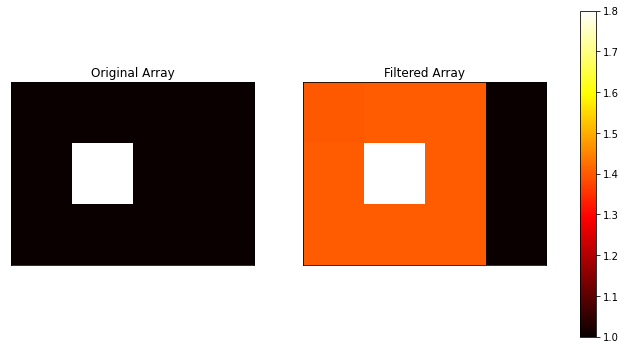

In [72]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
# Plot original array
axes[0].imshow(arr, cmap='hot', interpolation='nearest')
axes[0].set_title('Original Array')
axes[0].set_xticks([])
axes[0].set_yticks([])

# Plot filtered array
# Note: NaNs will be displayed with a different color (default is masked as white)
im = axes[1].imshow(result, cmap='hot', interpolation='nearest')
axes[1].set_title('Filtered Array')
axes[1].set_xticks([])
axes[1].set_yticks([])

# Add colorbar
fig.colorbar(im, ax=axes.ravel().tolist())

plt.show()

In [73]:
# Extract features (polygons) from the GeoJSON file using fiona
with fiona.open(nuts_path, "r") as geojson:
    features = [feature for feature in geojson if feature['properties']['id'] == current_nutsid]

In [74]:
crs

CRS.from_epsg(3035)

In [75]:
# here we just print the amout of data in a NUTS region
blurred_arrays =  []
median_arrays = []
arrays = []

for input_path in [croplandtif_path, grasslandtif_path, foresttif_path]:
    
    
    print(input_path)
    with rasterio.open(input_path) as src:
        for feature in features:
            
            geometry = feature["geometry"]
            nutsid = feature['properties']['id']


            # Mask and crop the raster using the current polygon
            out_image, out_transform = mask(src, [geometry], invert=False, crop=True)
            
            out_image = out_image.astype(float)  # Ensure the data is in float
            out_image[out_image == 255] = np.nan

            
            west =  out_transform[2]
            north = out_transform[5]
            
            
            resolution = src.res  # (pixel width, pixel height)

            # Get CRS
            crs = src.crs
            if crs is not None:
                # Extract EPSG code
                epsg_code = crs.to_epsg()  # This will be None if the EPSG code can't be determined


            affine = out_transform
            array = np.squeeze(out_image, axis = 0)
            
            unmasked_pixels = np.count_nonzero(array != np.nan)
            
            # fill in the pandas admin data
            if input_path == 'in_data/Corine_landcover/Crops_ptobability_final_layer_Poland.tif':
                aggregates.loc[aggregates.NUTSID == nutsid,'total_ha'] = unmasked_pixels
            
            
            # mask the 255 values
            array_mask = array == np.nan
            
            array = ma.array(array, mask = array_mask)
        
            # now blur
            
            
            blurred_array = convolve(array, kernel, mode='nearest')
            median_array  = median_filter(array, size=3)
            
            
            # Reapply the mask to the blurred band
            arrays.append(array)
            
            blurred_array = ma.array(blurred_array, mask = array_mask)
            blurred_arrays.append(blurred_array)
            
            median_array = ma.array(median_array, mask = array_mask)
            median_arrays.append(median_array)

            print(f"{nutsid}: {array.shape}. {unmasked_pixels} unmasked pixels")
            
print(epsg_code)
print(resolution)

in_data/Corine_landcover/Crops_ptobability_final_layer_Poland.tif
PL72: (1272, 1497). 1904184 unmasked pixels
in_data/Corine_landcover/Grass_ptobability_final_layer_Poland.tif
PL72: (1272, 1497). 1904184 unmasked pixels
out_data/PL_expert_map_integer.tif
PL72: (1272, 1497). 1904184 unmasked pixels
3035
(100.0, 100.0)


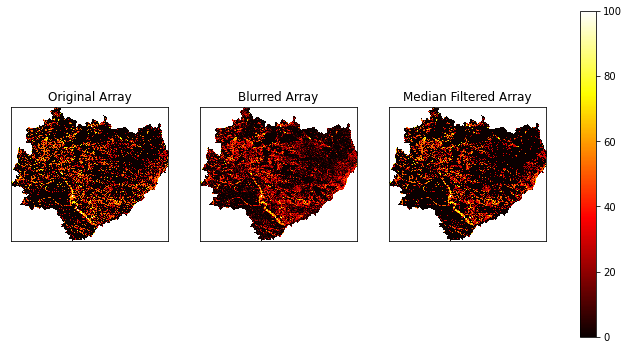

In [76]:

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))

arr = arrays[1].data
result = blurred_arrays[1].data
result_median = median_arrays[1].data

# Plot original array
axes[0].imshow(arr, cmap='hot', interpolation='nearest')
axes[0].set_title('Original Array')
axes[0].set_xticks([])
axes[0].set_yticks([])

# Plot blurred array
im = axes[1].imshow(result, cmap='hot', interpolation='nearest')
axes[1].set_title('Blurred Array')
axes[1].set_xticks([])
axes[1].set_yticks([])

# Plot median filtered array
im2 = axes[2].imshow(result_median, cmap='hot', interpolation='nearest')
axes[2].set_title('Median Filtered Array')
axes[2].set_xticks([])
axes[2].set_yticks([])

# Add colorbar for the last plot
fig.colorbar(im2, ax=axes.ravel().tolist())

plt.show()



In [77]:
x = 800
print(arr[x:(x+10),x:(x+10)])

[[ 0.  0.  0. 31. 53.  0. 31.  0.  0. 53.]
 [ 0.  0. 31.  0.  0.  0.  0.  0. 23. 53.]
 [ 0.  0. 31. 31.  0.  0.  0.  0.  0. 53.]
 [ 0.  0. 31.  0.  0.  0.  0.  0. 23. 31.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 31. 31.]
 [ 0. 31.  0.  0.  0. 53. 31. 53. 31. 31.]
 [ 0.  0.  0.  0.  0.  0. 31. 23. 31.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 31.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [78]:
# array3d = np.stack(median_arrays, axis = 0)
array3d = np.stack(blurred_arrays, axis = 0)
array3d_base = np.stack(arrays, axis = 0)

In [79]:
array3d.shape

(3, 1272, 1497)

In [80]:
aggregates['misc_ha'] = aggregates['total_ha'] - aggregates['forest_ha'] - aggregates['arable_ha'] - aggregates['grass_ha']

aggregates

,NUTSID,forest_ha,arable_ha,grass_ha,misc_ha,total_ha
0,PL,9254668,11009210,3149870,-23413748,0
1,PL92,830702,1224200,475490,-2530392,0
2,PL22,394773,278930,81700,-755403,0
3,PL51,595054,711890,131990,-1438934,0
4,PL52,250928,446400,37410,-734738,0
5,PL61,421942,973940,99600,-1495482,0
6,PL41,769351,1479650,237570,-2486571,0
7,PL62,762736,606550,314380,-1683666,0
8,PL42,817085,651860,153440,-1622385,0
9,PL63,667061,613740,127130,-1407931,0


In [81]:
array_mask = (array3d_base == 255) | np.isnan(array3d_base)
array_mask.shape

(3, 1272, 1497)

In [82]:
masked_array = ma.array(array3d, mask=array_mask)
masked_array.shape

(3, 1272, 1497)

In [83]:
masked_array[0]

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20)

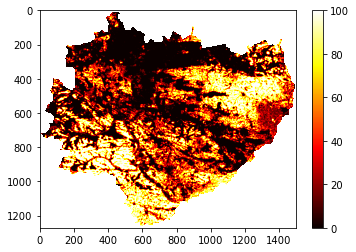

In [84]:
plt.imshow(masked_array[0], cmap='hot')
plt.colorbar()
plt.show()


In [85]:
masked_array[0, 0, 0]

masked

In [86]:
ma.is_masked(masked_array[0, 0, 0])

True

In [87]:
# lets have a transition matrix to map the values of the classes

# 1 = forest;
# 2 = arable cropland;
# 3 = permanent cropland;
# 4 = grassland;
# 5 = built-up; 
# 6 = other natural land; 
# 7 = the rest/not releva

# current: croplandtif_path, grasslandtif_path, foresttif_path]

In [101]:
translate_layer_idx_2_final = {2:1, 0:2, 1:4}

rev_translate_layer_idx_2_final = {v:k for (k,v) in translate_layer_idx_2_final.items()}
rev_translate_layer_idx_2_final

{1: 2, 2: 0, 4: 1}

In [89]:
# Flatten the array into a list of (row_index, column_index, value) tuples
flattened_with_indices = [(translate_layer_idx_2_final[i], j, k, masked_array[i, j, k]) 
                          for i in range(masked_array.shape[0]) # layers 
                          for j in range(masked_array.shape[1]) # rows
                          for k in range(masked_array.shape[2]) # cols
                          if not ma.is_masked(masked_array[i, j, k]) and not np.isnan(masked_array[i, j, k]) ]

flattened_with_indices

[(2, 2, 416, 74.2),
 (2, 2, 417, 52.599999999999994),
 (2, 2, 418, 34.6),
 (2, 2, 419, 22.9),
 (2, 2, 420, 12.3),
 (2, 3, 416, 87.3),
 (2, 3, 417, 70.1),
 (2, 3, 418, 44.800000000000004),
 (2, 3, 419, 24.7),
 (2, 3, 420, 16.1),
 (2, 3, 421, 7.2),
 (2, 3, 422, 0.0),
 (2, 3, 423, 5.1000000000000005),
 (2, 3, 424, 11.899999999999999),
 (2, 3, 425, 13.600000000000001),
 (2, 3, 426, 6.800000000000001),
 (2, 4, 416, 97.9),
 (2, 4, 417, 80.5),
 (2, 4, 418, 55.70000000000001),
 (2, 4, 419, 29.3),
 (2, 4, 420, 16.700000000000003),
 (2, 4, 421, 5.5),
 (2, 4, 422, 0.0),
 (2, 4, 423, 3.4000000000000004),
 (2, 4, 424, 8.5),
 (2, 4, 425, 8.5),
 (2, 4, 426, 3.4000000000000004),
 (2, 4, 427, 0.0),
 (2, 4, 428, 0.0),
 (2, 4, 429, 0.0),
 (2, 4, 430, 0.0),
 (2, 5, 416, 100.0),
 (2, 5, 417, 80.8),
 (2, 5, 418, 56.400000000000006),
 (2, 5, 419, 32.300000000000004),
 (2, 5, 420, 15.399999999999999),
 (2, 5, 421, 3.4000000000000004),
 (2, 5, 422, 0.0),
 (2, 5, 423, 1.7000000000000002),
 (2, 5, 424, 3.4000000

In [90]:
# Sort the list by value in descending order
flattened_sorted = sorted(flattened_with_indices, key=lambda x: x[3], reverse=True)
len(flattened_sorted)

3405850

In [91]:
set([x[0] for x in flattened_sorted])

{1, 2, 4}

In [51]:
# we need to align the urban mask with the array!!!!

In [92]:
# Linda asked me to hard-code fix the urban areas. 
# load an urban mask. flatten it, only take the urban pixels and put them at the top of the flattened_sorted list so they get assigned first
# and added to the seen pixels set automatically. 

with rasterio.open(urban_mask_path) as src:
    urban_mask, urban_mask_transform = mask(src, [geometry], invert=False, crop=True)
    
#     urban_mask = ma.array(urban_mask, mask=array_mask[0,:,:])


fixed_pixels =  [(5, j, k, 100* urban_mask[0, j, k]) 
                              for j in range(masked_array.shape[1]) 
                              for k in range(masked_array.shape[2]) 
                              if not ma.is_masked(masked_array[0, j, k]) and urban_mask[0, j, k] == 1  ]


len(fixed_pixels)

84238

In [93]:
array.shape

(1272, 1497)

In [94]:
urban_mask.shape

(1, 1272, 1497)

In [95]:
flattened_sorted = fixed_pixels +  flattened_sorted 

flattened_sorted[:10]

[(5, 10, 415, 100),
 (5, 11, 415, 100),
 (5, 12, 415, 100),
 (5, 12, 423, 100),
 (5, 12, 424, 100),
 (5, 13, 415, 100),
 (5, 13, 416, 100),
 (5, 13, 417, 100),
 (5, 13, 418, 100),
 (5, 13, 419, 100)]

In [ ]:
# 0 = -----
# 1 = forest;
# 2 = arable cropland;
# 3 = permanent cropland;
# 4 = grassland;
# 5 = built-up; 
# 6 = other natural land; 
# 7 = the rest/not releva


In [102]:
# this is from the input data
counter = [aggregates.loc[aggregates.NUTSID == nutsid,'grass_ha'].item(), 
          aggregates.loc[aggregates.NUTSID == nutsid,'arable_ha'].item(), 
          aggregates.loc[aggregates.NUTSID == nutsid,'forest_ha'].item()]

total_px = 1904184
# this is manually from Linda's PPT
# we need the order grass, crop, forest
counter = [98140, 464080, 339650 , len(fixed_pixels)]

counter = [0, 339650, 464080, 0, 98140, len(fixed_pixels), 0, 0]

In [97]:
flattened_sorted[15524]

(5, 330, 755, 100)

In [103]:
NUTSID = "PL91"
seen_px = set()
output = np.full(array3d.shape[1:3], 10, dtype = 'int')
output = ma.array(output, mask=array_mask[0])


for i, tupl in enumerate(flattened_sorted):
    idx = tupl[1:3]
    
    if idx in seen_px or counter[tupl[0]] < 1:
        continue
    else:
        output[idx] = tupl[0]
        seen_px.add(idx)
        counter[tupl[0]] -= 1

print(counter)

[0, 0, 0, 0, 0, 0, 0, 0]


In [104]:
from rasterio.transform import from_origin

data = output



# Define the transformation and metadata
transform = from_origin(west, north, resolution[0], resolution[1])
height, width = data.shape
crs = f"EPSG:{epsg_code}"  # Example CRS - replace with the appropriate CRS for your data

# Metadata dictionary
metadata = {
    'driver': 'GTiff',
    'height': height,
    'width': width,
    'count': 1,
    'dtype': 'int16',
    'crs': crs,
    'transform': transform,
    'nodata': 255 
}

# Write to a new TIFF file
with rasterio.open('out_data/predictions/landcover_fillup/PL72_prediction_kernel_newclasses.tif', 'w', **metadata) as dst:
    dst.write(data, 1)


In [60]:
# Counting the frequency of each element
unique_elements, counts = np.unique(output, return_counts=True)

# Creating a dictionary for better readability
frequency = dict(zip(['grassland', 'cropland', 'forest', 'urban', 'misc', 'na'], counts))

print(frequency)